<a href="https://colab.research.google.com/github/digitalemerge/ai-sensing-ignite2019-course/blob/master/CYBDV_0_9_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Can you beat DeepVariant?

In [0]:
# @markdown Copyright 2020 Google LLC. \
# @markdown SPDX-License-Identifier: Apache-2.0
# @markdown (license hidden in Colab)

# Copyright 2020 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/deepvariant/blob/r0.9/docs/cybdv_notebook.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/deepvariant/blob/r0.9/docs/cybdv_notebook.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

DeepVariant turns genomic data into a pileup image, and then uses a convolutional neural network (CNN) to classify these images. This notebook lets you try your hand at classifying these pileups, just like DeepVariant does.


DeepVariant gets over 99.8% of variants correct, so we chose the variants that were hardest to make this more interesting. The "difficult" variants were chosen because either DeepVariant was not very confident in its choice (lower than 90% likelihood of its top choice) or it made the wrong choice. We also selected 80 of the easy variants to start off with.


DeepVariant has not been trained on these variants. They are from the HG002 test set, labeled with "truth" from GIAB.

To play, go to `Runtime -> Run all`, then wait a bit until the game starts running (under "Play the game: EASY").

The Preparation section below contains setup code that is hidden for clarity. Expand it if you are curious about the details, or just skip down to "Play the game".



# Preparation

## Installs and imports

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [0]:
%%capture
# Don't worry if you see a `Failed building wheel` error, nucleus will still be installed correctly.
! pip install "google-nucleus"

In [0]:
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow.core.example import example_pb2
from nucleus.protos import variants_pb2
from nucleus.util import vis

## Download file with consolidated locus information
This is a combination of the make_examples output (containing the pileup tensors), the call_variants output (containing the CNN's output likelihoods to give us DeepVariant's answer), and GIAB ground truth labels.

#### Download data

In [0]:
EASY_INPUT='gs://deepvariant/cybdv/cybdv_0.9.0_easy.tfrecord.gz'
DIFFICULT_INPUT='gs://deepvariant/cybdv/cybdv_0.9.0_difficult.tfrecord.gz'

easy_input='easy.tfrecord.gz'
difficult_input='difficult.tfrecord.gz'
! time gsutil cp $EASY_INPUT $easy_input
! time gsutil cp $DIFFICULT_INPUT $difficult_input

Copying gs://deepvariant/cybdv/cybdv_0.9.0_easy.tfrecord.gz...
/ [1 files][940.2 KiB/940.2 KiB]                                                
Operation completed over 1 objects/940.2 KiB.                                    

real	0m2.534s
user	0m0.739s
sys	0m0.343s
Copying gs://deepvariant/cybdv/cybdv_0.9.0_difficult.tfrecord.gz...
\ [1 files][ 61.1 MiB/ 61.1 MiB]                                                
Operation completed over 1 objects/61.1 MiB.                                     

real	0m2.856s
user	0m0.913s
sys	0m0.360s


In [0]:
! ls -ltrsh

total 63M
4.0K drwxr-xr-x 1 root root 4.0K May  4 16:26 sample_data
944K -rw-r--r-- 1 root root 941K May 12 20:47 easy.tfrecord.gz
 62M -rw-r--r-- 1 root root  62M May 12 20:47 difficult.tfrecord.gz


## Data wrangling and inspection

In [0]:
# Create a Dataset object for each set of tfrecords
raw_difficult_dataset = tf.data.TFRecordDataset(difficult_input, compression_type="GZIP")
raw_easy_dataset = tf.data.TFRecordDataset(easy_input, compression_type="GZIP")

In [0]:
# We can inspect an example to see what is inside:
for e in raw_easy_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(e.numpy())
  print(example)

features {
  feature {
    key: "difficulty"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "genotypes"
    value {
      bytes_list {
        value: "\n\314\217\010\n\014\n\003alt\022\005\n\003\n\001T\n\021\n\010dv_label\022\005\032\003\n\001\002\n*\n\026genotype_probabilities\022\020\022\016\n\014\241\237\0367\220`[7\206\376\177?\n\024\n\013truth_label\022\005\032\003\n\001\002\n\320\216\010\n\007example\022\303\216\010\n\277\216\010\n\273\216\010\n\267\216\010\n\027\n\014image/format\022\007\n\005\n\003raw\n\025\n\014variant_type\022\005\032\003\n\001\001\nf\n\017variant/encoded\022S\nQ\nO2\001C:\001TZ;\022\022\n\003VAF\022\013\n\t\021\000\000\000\000\000\000\360?\022\016\n\002AD\022\010\n\0028\000\n\0028\022\022\n\n\002DP\022\004\n\0028\022:\002\001\001J\005HG002h\217\3326r\0011\200\001\216\3326\n%\n\032alt_allele_indices/encoded\022\007\n\005\n\003\n\001\000\n\223\214\010\n\rimage/encoded\022\200\214\010\n\374\213\010\n\370\213\010\036\376\3

### Top-level parsing of each locus

We can often work with the examples from there, but TensorFlow has some nice methods for filtering if we first tell it about the structure of the example and how to parse the features:

In [0]:
# Describe the features. These were defined in the prep script and can also be inspected above.
consolidated_variant_description = {
  'locus_id': tf.io.FixedLenFeature([], tf.string),
  'multiallelic': tf.io.FixedLenFeature([], tf.int64),
  'difficulty': tf.io.FixedLenFeature([], tf.int64),
  'genotypes': tf.io.VarLenFeature(tf.string)
}

# Quick parsing at the top level
def quick_parse_locus(locus_proto):
  return tf.io.parse_single_example(locus_proto, consolidated_variant_description)

difficult_dataset = raw_difficult_dataset.map(quick_parse_locus)
easy_dataset = raw_easy_dataset.map(quick_parse_locus)

In [0]:
for e in easy_dataset.take(1):
  print(e)

{'genotypes': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f64ab3fd198>, 'difficulty': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'locus_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1:896270_C'>, 'multiallelic': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


### Filtering to useful subsets of the datasets

We have only included 80 easy examples (out of over 3 million) along with all difficult examples.

In [0]:
# Simple counter
def count_calls(calls):
  count = 0
  for c in calls:
    count += 1
  return count

print('Number of easy examples:', count_calls(easy_dataset))
print('Number of difficult examples:', count_calls(difficult_dataset))

Number of easy examples: 80
Number of difficult examples: 5696


The parsing above is only at the top level, and we will parse those binary 'variant' and 'genotypes' fields next, but first we can start to do some filtering using the simple features, namely 'multiallelic' and 'difficulty':

In [0]:
# A few examples of easy variants
easy_biallelics = easy_dataset.filter(lambda x: tf.equal(x['multiallelic'], False))
easy_multiallelics = easy_dataset.filter(lambda x: tf.equal(x['multiallelic'], True))

# Where DeepVariant had less than 90% likelihood for its choice OR it chose wrong
difficult_biallelics = difficult_dataset.filter(lambda x: tf.equal(x['multiallelic'], False))
difficult_multiallelics = difficult_dataset.filter(lambda x: tf.equal(x['multiallelic'], True))

# In the prep script, we set difficult=100 when DeepVariant's top choice did not match the truth (i.e. DeepVariant got it wrong)
dv_missed = difficult_dataset.filter(lambda x: tf.equal(x['difficulty'], 100))

# Optional counting of examples (commented out as these take several seconds to run)
# Uncomment these if you want to see the counts of different types of variants.
# print('easy_biallelics count:', count_calls(easy_biallelics))
# print('easy_multiallelics count:', count_calls(easy_multiallelics))
# print('difficult_biallelics count', count_calls(difficult_biallelics))
# print('difficult_multiallelics count:', count_calls(difficult_multiallelics))
# print('dv_missed count:', count_calls(dv_missed))

### Parsing genotypes within each locus

Similar to what we did at the top level, unwrap each genotype, parse the nested protos in 'variant' and each genotype's 'example', and then turn all the remaining types into native Python data structures:

In [0]:
def bytes_to_str(b):
  if isinstance(b, type('')):
    return b
  elif isinstance(b, type(b'')):
    return b.decode()
  else:
    raise ValueError('Incompatible type: {}. Expected bytes or str.'.format(type(b)))

def fully_parse_locus(top_level_parsed):
  # where top_level_parsed = tf.io.parse_single_example(locus_proto, consolidated_variant_description)

  def _clean_locus(locus):
    return {
        'locus_id': bytes_to_str(locus['locus_id'].numpy()),
        'multiallelic': bool(locus['multiallelic'].numpy()),
        'genotypes': locus['genotypes'],
        'difficulty': locus['difficulty']
    }
  clean_locus = _clean_locus(top_level_parsed)
  genotype_description = {
    'example': tf.io.FixedLenFeature([], tf.string),
    'truth_label': tf.io.FixedLenFeature([], tf.int64),
    'genotype_probabilities': tf.io.VarLenFeature(tf.float32),
    'dv_correct': tf.io.FixedLenFeature([], tf.int64),
    'dv_label': tf.io.FixedLenFeature([], tf.int64),
    'alt': tf.io.FixedLenFeature([], tf.string)
  }
  def _parse_genotype(sub_example):
    return tf.io.parse_single_example(sub_example, genotype_description)

  def _clean_genotype(e):
    genotype_example = tf.train.Example()
    genotype_example.ParseFromString(e['example'].numpy())
    return {
        'genotype_probabilities': list(e['genotype_probabilities'].values.numpy()),
        'dv_correct': bool(e['dv_correct'].numpy()),
        'dv_label': e['dv_label'].numpy(),
        'truth_label': e['truth_label'].numpy(),
        'example': genotype_example,
        'alt': bytes_to_str(e['alt'].numpy())
    }


  genotypes = clean_locus['genotypes'].values
  parsed_genotypes = []
  for s in genotypes:
    genotype_dict = _parse_genotype(s)
    clean_genotype_dict = _clean_genotype(genotype_dict)
    parsed_genotypes.append(clean_genotype_dict)

  clean_locus['genotypes'] = parsed_genotypes
  return clean_locus

Let's look at one locus:

In [0]:
for e in easy_biallelics.take(1):
  example = fully_parse_locus(e)
  print(example)

{'locus_id': '1:896270_C', 'multiallelic': False, 'genotypes': [{'genotype_probabilities': [9.4547e-06, 1.30759e-05, 0.99997747], 'dv_correct': True, 'dv_label': 2, 'truth_label': 2, 'example': features {
  feature {
    key: "alt_allele_indices/encoded"
    value {
      bytes_list {
        value: "\n\001\000"
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\036\376\376F\2302\036\376\376F\2302\372\376\376F\2302\036\376\376F\2302\036\376\376F\2302\264\376\376F\2302\036\376\376F\2302\036\376\376F\2302\264\376\376F\2302\036\376\376F\2302\372\376\376F\2302\264\376\376F\2302\036\376\376F\2302\036\376\376F\2302\264\376\376F\2302\036\376\376F\2302\036\376\376F\2302\264\376\376F\2302\264\376\376F\2302\036\376\376F\2302\264\376\376F\2302d\376\376F\2302\264\376\376F\2302\372\376\376F\2302\264\376\376F\2302d\376\376F\2302\264\376\376F\2302\264\376\376F\2302\264\376\376F\2302\036\376\376F\2302\264\376\376F\2302\264\376\376F\2302\264\376\376F\

### Inspecting some loci

In [0]:
def pretty_print_locus(locus):
  # initial information:
  allelic_string = "Multiallelic" if locus['multiallelic'] else "Biallelic" 
  print("%s -- %s: %d example%s" % (locus['locus_id'], allelic_string, len(locus['genotypes']), "s" if locus['multiallelic'] else ""))

def show_all_genotypes(genotypes):
  # Show pileup images for all genotypes
  for g in genotypes:
    vis.draw_deepvariant_pileup(example=g['example'])
    # And here's how DeepVariant did:
    print("Truth: %d, DeepVariant said: %d, Correct: %s" % (g['truth_label'], g['dv_label'], g['dv_correct']))
    print("DeepVariant genotype likelihoods:", g['genotype_probabilities'])
    print("\n\n")

def show_loci(loci, show_pileups=True):
  for raw_locus in loci:
    if show_pileups:
      print("_____________________________________________________________")
    locus = fully_parse_locus(raw_locus)
    pretty_print_locus(locus)
    if show_pileups:
      show_all_genotypes(locus['genotypes'])


_____________________________________________________________
1:896270_C -- Biallelic: 1 example


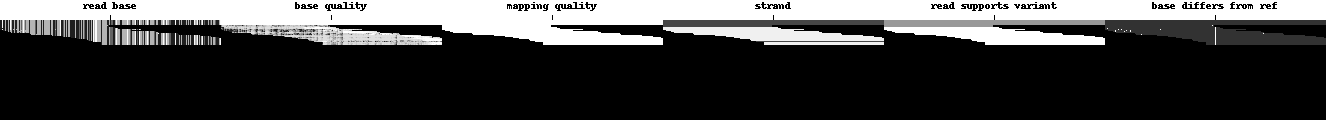

Truth: 2, DeepVariant said: 2, Correct: True
DeepVariant genotype likelihoods: [9.4547e-06, 1.30759e-05, 0.99997747]





In [0]:
show_loci(easy_biallelics.take(1))

_____________________________________________________________
1:9856018_CAA -- Multiallelic: 3 examples


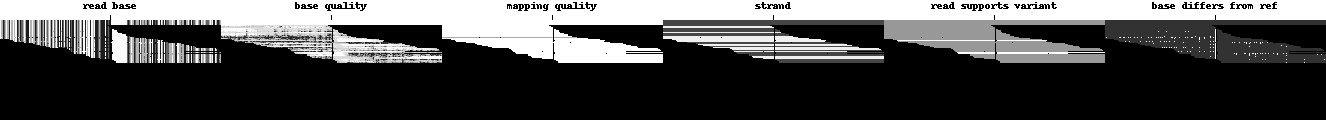

Truth: 0, DeepVariant said: 0, Correct: True
DeepVariant genotype likelihoods: [0.994089, 0.005899814, 1.11786e-05]





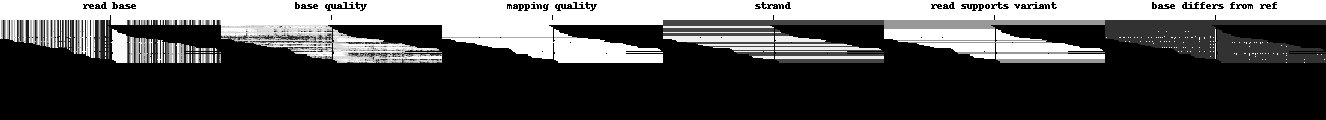

Truth: 2, DeepVariant said: 2, Correct: True
DeepVariant genotype likelihoods: [9.37013e-05, 0.008140382, 0.9917659]





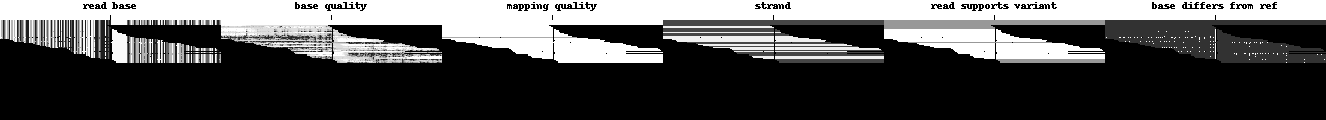

Truth: 2, DeepVariant said: 2, Correct: True
DeepVariant genotype likelihoods: [2.00745e-05, 0.0002286557, 0.99975127]





In [0]:
show_loci(easy_multiallelics.take(1))

All multiallelic loci will have at least 3 examples (pileup tensors) because there is one for each set of one or two alternate alleles. Those with three alternate alleles produce 6 examples.

In [0]:
show_loci(difficult_multiallelics.take(10), show_pileups=False)

1:194112316_T -- Multiallelic: 3 examples
2:130397840_GGT -- Multiallelic: 3 examples
2:182813337_TTTTCTTTCTTTC -- Multiallelic: 6 examples
3:30941293_AGTGTGTGTGTGTGT -- Multiallelic: 6 examples
3:124125678_C -- Multiallelic: 6 examples
3:188317538_G -- Multiallelic: 3 examples
5:102883892_T -- Multiallelic: 3 examples
5:132835059_T -- Multiallelic: 6 examples
6:12399702_CAAAAA -- Multiallelic: 3 examples
6:22191313_GAA -- Multiallelic: 3 examples


## Set up the game-play code

In [0]:
WRITE_NORMAL = "\x1b[0m"
WRITE_GREEN_BACKGROUND = "\x1b[102m"
WRITE_RED_BACKGROUND = "\x1b[101m"

def play_game(calls, pro_mode=False, put_results_here=None):
  """
  Args:
    put_results_here: a list, allows saving results along the way even if the player stops the loop
  """
  # for example, calls = dataset.take(5)
  print("Can you beat DeepVariant?: type 0, 1, or 2 just like DeepVariant's CNN would for each example.")
  results = []
  score = 0
  total = 0
  dv_score = 0
  for c in calls:
    locus = fully_parse_locus(c)
    print("___________________________________________________________")
    print(locus['locus_id'])
    allelic_string = "Multiallelic" if locus['multiallelic'] else "Biallelic" 
    print("%s: %d example%s" % (allelic_string, len(locus['genotypes']), "s" if locus['multiallelic'] else ""))
    quit_early = False
    # For every genotype, show the user the images and ask for their guess
    for e in locus['genotypes']:
      # Draw pileups:
      vis.draw_deepvariant_pileup(example=e['example'])
      print('Genotype in question: ', e['alt'])
      # Ask user until we get a 0, 1, or 2
      while True:
        try:
          guess = input("Your answer (0, 1, or 2):")
          if guess in ['exit', 'quit', 'q']:
            quit_early = True
            break
          guess = int(guess)
          if guess in [0,1,2]:
            break
          else:
            print("Please enter only 0, 1, or 2.")
        except:
          print("Please enter only 0, 1, or 2. Or enter q to quit.")
          continue
      if quit_early:
        break
      truth = e['truth_label']
      if truth == guess:
        print(WRITE_GREEN_BACKGROUND + "You are correct!", WRITE_NORMAL)
        score += 1
      else:
        print(WRITE_RED_BACKGROUND + "Nope! Sorry it's actually", truth, WRITE_NORMAL)
      total += 1
      # And here's how DeepVariant did:
      if e['dv_correct']:
        dv_score += 1
      dv_result_string = WRITE_GREEN_BACKGROUND + "is correct" + WRITE_NORMAL if e['dv_correct'] else WRITE_RED_BACKGROUND + "failed" + WRITE_NORMAL
      print("DeepVariant %s with likelihoods:" % (dv_result_string), e['genotype_probabilities'])
      result = {'id': locus['locus_id'], 'truth': truth, 'guess': guess, 'dv_label': e['dv_label']}
      if pro_mode:
        result['user_supplied_classification'] = input("Classification?")
      if put_results_here != None:
        put_results_here.append(result)
      results.append(result)
    if quit_early:
      break
  print("=============================================================")
  print("=============================================================")
  print("=============================================================")
  print("Your score is", score, "/", total)
  print("DeepVariant's score is", dv_score)
  return results

# Now let's play the game!

## Play the game: EASY

These are examples that DeepVariant was at least 99% sure about and got correct. Think of this as a tutorial. Once you can easily get them all right, try the difficult examples below.

Your job is to pick 0, 1, or 2, depending on how many copies of the given alternate allele you see in the pileup.

Can you beat DeepVariant?: type 0, 1, or 2 just like DeepVariant's CNN would for each example.
___________________________________________________________
1:5248540_T
Biallelic: 1 example


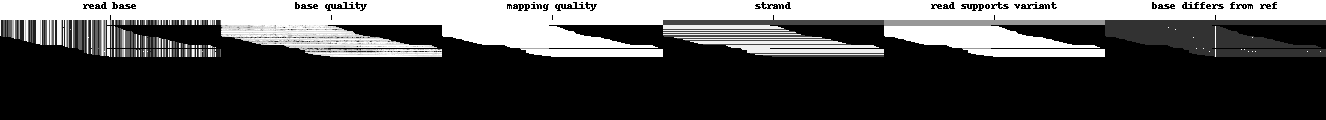

Genotype in question:  C
Your answer (0, 1, or 2):C
Please enter only 0, 1, or 2. Or enter q to quit.
Your answer (0, 1, or 2):0
Nope! Sorry it's actually 2 
DeepVariant is correct with likelihoods: [6.497e-07, 1.2576e-06, 0.9999981]
___________________________________________________________
1:6848504_C
Biallelic: 1 example


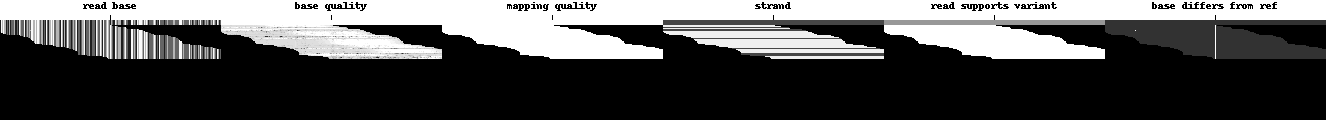

Genotype in question:  A


In [0]:
easy_biallelic_results = play_game(easy_biallelics.shuffle(80).take(6))

## Play the game: DIFFICULT

In [0]:
difficult_biallelic_results = play_game(difficult_biallelics.shuffle(1000).take(10))

## Play the game: Multiallelics only

For multiallelics, it's possible to cheat because the pileups are related. Once you know the answer to one or two pileups, you can use that information to help infer the remaining calls. Note that DeepVariant doesn't get this information, so you have an unfair advantage here.

Just be careful, the `base differs from ref` channel will light up for ALL alt alleles. Pay more attention to the reads highlighted (white) in the `read supports variant` channel, and choose 0, 1, or 2 depending on how many copies of THIS alternate allele are shown.

In [0]:
easy_multiallelic_results = play_game(easy_multiallelics.shuffle(9).take(3))

In [0]:
difficult_multiallelic_results = play_game(difficult_multiallelics.shuffle(50).take(3))